<h1> This Climate change: its impact on aviation on schedule disruption

<p>There is justifiably a good deal of analysis of aviation's impact on climate change.

Fewer column inches have been given to the impact of climate change on aviation.

The main expected impacts of climate change on aviation result from changes in temperature, precipitation (rain and snow), storm patterns, sea level and wind patterns. In addition, climate change is expected to lead to increased drought, impacts on the supply of water and energy, and changes in wildlife patterns and biodiversity. Consequences for aviation include reduced aircraft performance, changing demand patterns, potential damage to infrastructure, <b>loss of capacity and schedule disruption</b>.</p>
<h4>****Based on dataset 2008 and 2015 and 2020 on Jan</h4>

In [8]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")
from datetime import datetime
import sqlalchemy
from sqlalchemy import create_engine
import pymysql

In [9]:
#import cleaned dataset 
df1= pd.read_csv("Jan_2008_final.csv", index_col=0)
df1.head(2)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,0.0,0.0,0.0,0.0,0.0
1,2008,1,3,4,754.0,735,1002.0,1000,WN,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,0.0,0.0,0.0,0.0,0.0


Analysis of flight delay and causal factors is crucial in maintaining airspace efficiency and safety. However, delay samples are not independent since they always show a certain aggregation pattern. Therefore, this anaysis develops to explore the delay and causal factors which is able to take dependence and the possible problem involved including error correlation and variable lag effect of causal factors on delay into account. The study first explores the delay aggregation pattern by measuring and quantifying the spatial dependence of delay. 

Moreover, the outcomes suggest that, aside from the well-known weather and flow control factors, delay-reduction strategies also need to pay more attention to reducing the impact of delay at the previous airport.

<h1> 1. Print out average time airlines will arrive to their gate

In [11]:
Total_delay = df1['ArrDelay'].sum()
Total_rows = len(df1.index)

print(Total_delay / Total_rows)

42.65876410555395


<h4>1.NAS Delay:</h4>

Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather
conditions, airport operations, heavy traffic volume, air traffic control, etc. Delays that occur after 
Actual Gate Out are usually attributed to the NAS and are also reported through OPSNET.

<h4>2. OPSNET Delay Cause:</h4>

Delays to Instrument Flight Rules (IFR) traffic of 15 minutes or more, experienced by individual flights, 
which result from the ATC system detaining an aircraft at the gate, short of the runway, on the runway, 
on a taxiway, and/or in a holding configuration anywhere en route.

Such delays include delays due to weather conditions at airports and en route (Weather), FAA and non-FAA 
equipment malfunctions (Equipment), the volume of traffic at an airport (Volume), reduction to runway capacity 
(Runway), and other factors (Others). Flight delays of less than 15 minutes are not reported in OPSNET. 

In [25]:
df = df1.loc[(df1['NASDelay'] != 0, ['ArrDelay'])]
df.head()

ArrDelay    4045709.0
dtype: float64

In [31]:
df_air_system = df1.loc[(df1['NASDelay'] > 0, ['ArrDelay'])].sum()
df.head()

ArrDelay    60732
dtype: int64

In [32]:
df_air_system = df1.loc[(df1['NASDelay'] < 0, ['ArrDelay'])].sum()
df.head()

ArrDelay    60732
dtype: int64

In [33]:
df_air_system = df1.loc[(df1['NASDelay'] > 0, ['ArrDelay'])].count()
df.head()

ArrDelay    60732
dtype: int64

In [47]:
df = df1.loc[(df1['NASDelay'] != 0, ['ArrDelay'])]

delays_airsys = df1.loc[(df1['NASDelay'] > 0, ['ArrDelay'])].sum()
notdelayed_airsys = df1.loc[(df1['NASDelay'] <= 0, ['ArrDelay'])].sum()

count_sys = df1[(df1['NASDelay'] != 0)].count()
count_sys_pos = df1.loc[(df1['NASDelay'] > 0, ['ArrDelay'])].count()

<h4>3. Security Delay:</h4>

Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security 
breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.

In [38]:
df = df1.loc[(df1['SecurityDelay'] != 0, ['ArrDelay'])]

delays_airsec = df1.loc[(df1['SecurityDelay'] > 0, ['ArrDelay'])].sum()
notdelayed_airsec = df1.loc[(df1['SecurityDelay'] <= 0, ['ArrDelay'])].sum()

count_sec = df[(df1['SecurityDelay'] != 0)].count()
count_sec_pos = df1.loc[(df1['SecurityDelay'] > 0, ['ArrDelay'])].count()


<h4>3.Carrier Delay:</h4>

Carrier delay is within the control of the air carrier. Examples of occurrences that may determine carrier delay
are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird 
strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), 
damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory 
servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, 
stowing carry-on baggage, weight and balance delays.

In [41]:
df = df1.loc[(df1['CarrierDelay'] != 0, ['ArrDelay'])]

delays_airair = df1.loc[(df1['CarrierDelay'] > 0, ['ArrDelay'])].sum()
notdelayed_airair = df1.loc[(df1['CarrierDelay'] <= 0, ['ArrDelay'])].sum()

count_air = df[(df1['CarrierDelay'] != 0)].count()
count_air_pos = df1.loc[(df1['CarrierDelay'] > 0, ['ArrDelay'])].count()

<h4>4.Late Arrival Delay:</h4>
Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple 
effect of an earlier delay at downstream airports is referred to as delay propagation.

In [49]:
df = df1.loc[(df1['LateAircraftDelay'] != 0, ['ArrDelay'])]

delays_airlate = df1.loc[(df1['LateAircraftDelay'] > 0, ['ArrDelay'])].sum()
notdelayed_airlate = df1.loc[(df1['LateAircraftDelay'] <= 0, ['ArrDelay'])].sum()

count_late = df[(df1['LateAircraftDelay'] != 0)].count()
count_late_pos = df1.loc[(df1['LateAircraftDelay'] > 0, ['ArrDelay'])].count()

<h4>5. Weather Delay:</h4>

Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves
on point of departure, enroute, or on point of arrival.


In [51]:
df = df1.loc[(df1['WeatherDelay'] != 0, ['ArrDelay'])]

delays_airweather = df1.loc[(df1['WeatherDelay'] > 0, ['ArrDelay'])].sum()
notdelayed_airweather = df1.loc[(df1['WeatherDelay'] <= 0, ['ArrDelay'])].sum()

count_weather = df[(df1['WeatherDelay'] != 0)].count()
count_weather_pos = df1.loc[(df1['WeatherDelay'] > 0, ['ArrDelay'])].count()

<h3>****Summery on delay and not delayed****</h3> 

In [54]:

delays = []
only_delays = []

# Average delay time accounting for delayed and not delayed flights

system = (delays_airsys + notdelayed_airsys) / count_sys
security = (delays_airsec + notdelayed_airsec) / count_sec
airline = (delays_airair + notdelayed_airair) / count_air
late = (delays_airlate + notdelayed_airlate) / count_late
weather = (delays_airweather + notdelayed_airweather) / count_weather

# Average delay time NOT accounting non-delayed flights

system_pos = delays_airsys / count_sys_pos
security_pos = delays_airsec / count_sec_pos
airline_pos = delays_airair  / count_air_pos
late_pos = delays_airlate / count_late_pos
weather_pos = delays_airweather/ count_weather_pos

# Append to array to ease access later

delays.append(system)
delays.append(security)
delays.append(airline)
delays.append(late)
delays.append(weather)

# Append only delayed flights

only_delays.append(system_pos)
only_delays.append(security_pos)
only_delays.append(airline_pos)
only_delays.append(late_pos)
only_delays.append(weather_pos)

# Print average times

delays


[ActualElapsedTime         NaN
 AirTime                   NaN
 ArrDelay             128.9112
 ArrTime                   NaN
 CRSArrTime                NaN
 CRSDepTime                NaN
 CRSElapsedTime            NaN
 CarrierDelay              NaN
 DayOfWeek                 NaN
 DayofMonth                NaN
 DepDelay                  NaN
 DepTime                   NaN
 Dest                      NaN
 Distance                  NaN
 LateAircraftDelay         NaN
 Month                     NaN
 NASDelay                  NaN
 Origin                    NaN
 SecurityDelay             NaN
 UniqueCarrier             NaN
 WeatherDelay              NaN
 Year                      NaN
 dtype: float64,
 ArrDelay    10637.275815
 dtype: float64,
 ArrDelay    122.660238
 dtype: float64,
 ArrDelay    115.443547
 dtype: float64,
 ArrDelay    810.626941
 dtype: float64]

In [56]:
print(only_delays)

[ArrDelay    66.615771
dtype: float64, ArrDelay    38.10462
dtype: float64, ArrDelay    56.874708
dtype: float64, ArrDelay    62.886061
dtype: float64, ArrDelay    81.445434
dtype: float64]


Text(0.5, 1.0, 'All Delays')

<Figure size 1440x576 with 0 Axes>

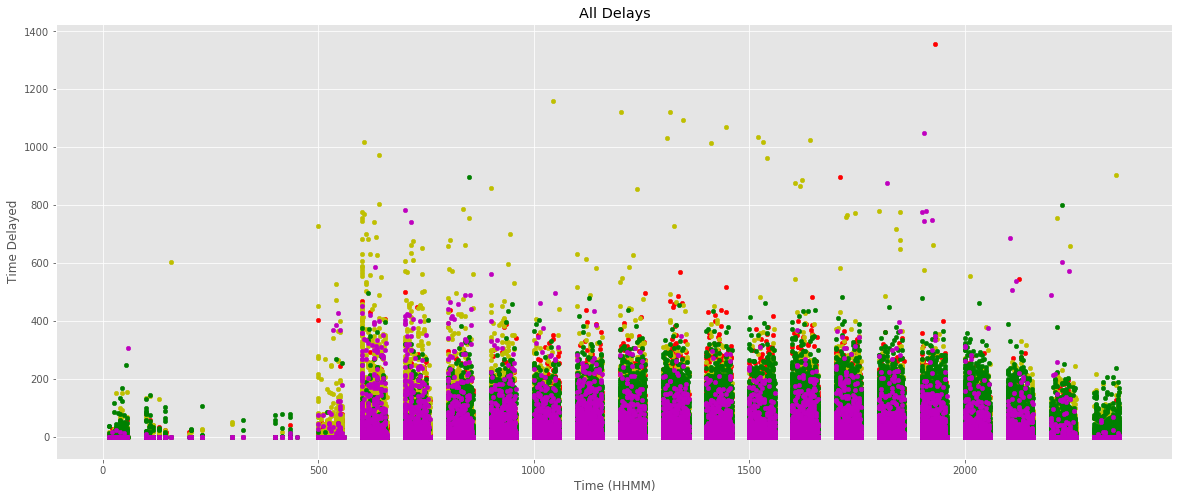

In [59]:
#Ploting 
plt.figure(figsize=(20, 8))


# Print each delayed flight due to all reasons

ax1 = df1.plot(kind='scatter', x='CRSDepTime', y='NASDelay',figsize=(20,8), color='r')
ax2 = df1.plot(kind='scatter', x='CRSDepTime', y='SecurityDelay', color='b', ax=ax1)
ax3 = df1.plot(kind='scatter', x='CRSDepTime', y='CarrierDelay', color='y', ax=ax1)
ax4 = df1.plot(kind='scatter', x='CRSDepTime', y='LateAircraftDelay', color='g', ax=ax1)
ax5 = df1.plot(kind='scatter', x='CRSDepTime', y='WeatherDelay', color='m', ax=ax1)


# Plot, plot, plot!

ax1.set_xlabel("Time (HHMM)")
ax1.set_ylabel("Time Delayed")
plt.title('All Delays')

Text(0.5, 1.0, 'Weather Delays')

<Figure size 1440x576 with 0 Axes>

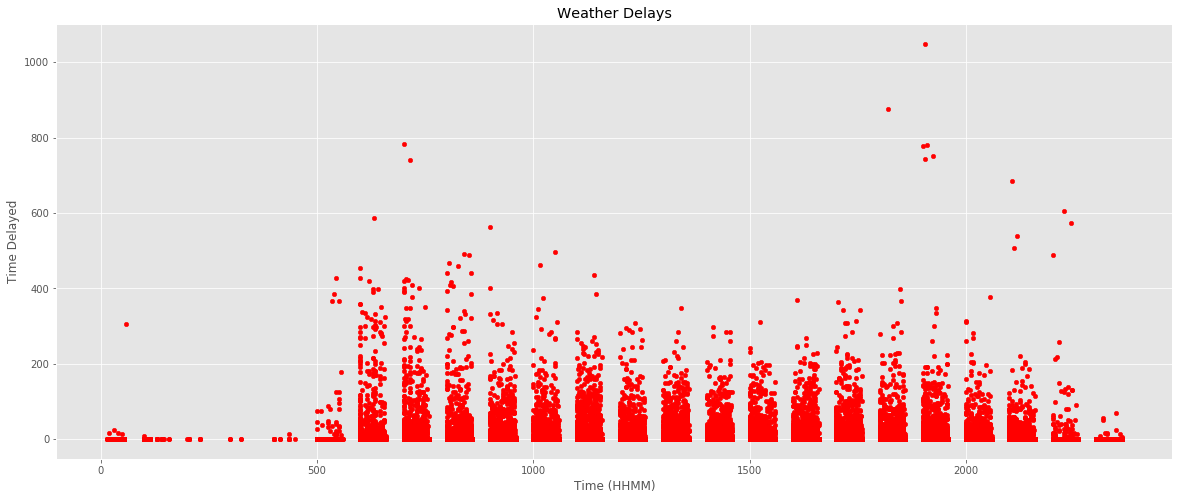

In [62]:
plt.figure(figsize=(20, 8))
ax1 = df1.plot(kind='scatter', x='CRSDepTime', y='WeatherDelay', figsize=(20,8), color='r')
ax1.set_xlabel("Time (HHMM)")
ax1.set_ylabel("Time Delayed")
plt.title('Weather Delays')

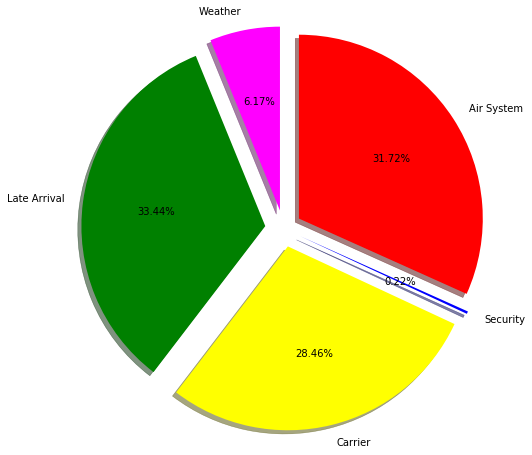

In [63]:
labels = 'Weather', 'Late Arrival', 'Carrier', 'Security', 'Air System'
sizes = [delays_airweather, delays_airlate, delays_airair, delays_airsec, delays_airsys]
explode = (0.1, 0.1, 0.1, 0.1, 0.1)
colors=['magenta','green','yellow','blue','red']

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, colors=colors,labels=labels, autopct='%1.2f%%',
        shadow=True, explode=explode, startangle=90, center=(0,0))
ax1.axis('equal')


plt.show()